# Time-Text, Text-Time, Baseline Experiment

In [ ]:
import torch
from diffusers import TimeStableDiffusionPipeline, StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from PIL import Image
from ip_adapter import TimeIPAdapter
import time
import yaml
import os

In [2]:
import matplotlib.pyplot as plt

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def plot_weights(title, inference_steps, text_weights, time_weights, fig_name):
    plt.style.use(plt.style.available[10])

    # Text weight plot
    plt.plot(inference_steps, text_weights, label='Text Weight', color='blue', linewidth=2, alpha=0.8)
    
    # Time weight plot
    plt.plot(inference_steps, time_weights, label='Time Weight', color='red', linewidth=2, alpha=0.8)

    plt.xlim(1000, 0)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Labels and title
    plt.xlabel('Inference Step', fontsize=12)
    plt.ylabel('Weight', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    
    # Show legend
    plt.legend(loc='upper left', fontsize=10)

    # Display the plot
    plt.savefig(fig_name)
    plt.show()
    
def save_config(input_image_path, output_image_path, text_prompt, type, scale, config_path):
    config_data = {
        "Input image" : input_image_path,
        "Output image": output_image_path,
        "Text" : text_prompt,
        "Type": type,
        "Scale": scale,
    }
    try:
        with open(config_path, 'r') as file:
            existing_data = yaml.safe_load(file)
            if existing_data is None:
                existing_data = []
    except FileNotFoundError:
        existing_data = []
    if isinstance(existing_data, list):
        existing_data.append(config_data)
    else:
        existing_data = [existing_data, config_data]
    with open(config_path, 'w') as file:
        yaml.dump(existing_data, file, default_flow_style=False)

In [3]:
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "../models/image_encoder/"  # https://huggingface.co/h94/IP-Adapter
ip_ckpt = "../models/ip-adapter_sd15.bin"  # https://huggingface.co/h94/IP-Adapter
device = "cuda:0"

In [ ]:
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

# load SD pipeline
pipe_time = TimeStableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)
pipe_base = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)
# load ip-adapter
ip_model_time = TimeIPAdapter(pipe_time, image_encoder_path, ip_ckpt, device, time_attention=True)
ip_model_base = TimeIPAdapter(pipe_base, image_encoder_path, ip_ckpt, device, time_attention=False)

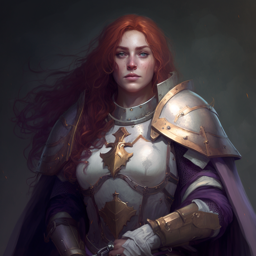

In [5]:
# read image prompt
input_image_path = "../assets/images/woman.png"
image = Image.open(input_image_path)
image.resize((256, 256))

In [83]:
text_prompt = "best quality, high quality, a woman standing in front of neon-lit skyscrapers"

scale = 1.0

  0%|          | 0/50 [00:00<?, ?it/s]

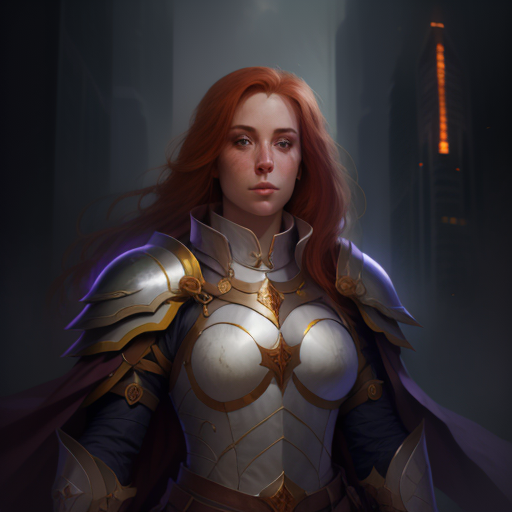

In [84]:
# baseline with multi prompt
type = "base"
timestamp = time.strftime("%m%d%H%M%S")
output_image_path = os.getcwd() + f"/result/TI-IT-baseline/{type}_{timestamp}.png"
config_path = os.getcwd() + "/result/TI-IT-baseline/config.yaml"

images = ip_model_base.generate(pil_image=image, num_samples=2, num_inference_steps=50, seed=42,
        prompt=text_prompt, scale=scale, TI=None)
# grid = image_grid(images, 1, 1)
images = images[0]
images.show()
images.save(output_image_path)
save_config(input_image_path, output_image_path, text_prompt, type, scale, config_path)

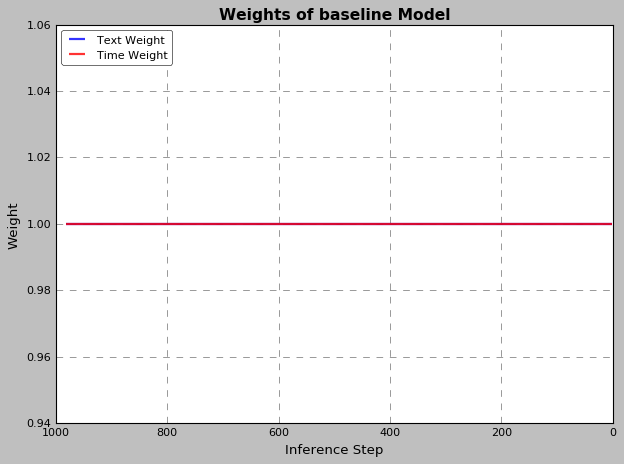

In [338]:
# Baseline weights
title = "Weights of baseline Model"
inference_steps, _,  _= ip_model_time.get_weights()
text_weights = [1] * len(inference_steps)
ip_weights = [1] * len(inference_steps)
plt = plot_weights(title, inference_steps, text_weights, ip_weights, "./result/TI-IT-baseline/weights/base_weights.png")

  0%|          | 0/50 [00:00<?, ?it/s]

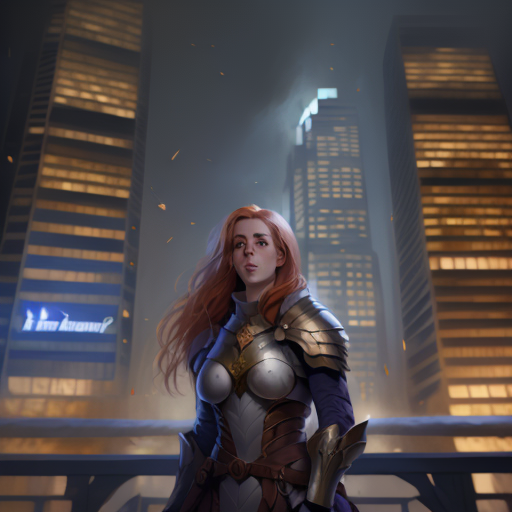

In [85]:
# TI with multi prompt
type = "ti"
timestamp = time.strftime("%m%d%H%M%S")
output_image_path = os.getcwd() + f"/result/TI-IT-baseline/{type}_{timestamp}.png"
config_path = os.getcwd() + "/result/TI-IT-baseline/config.yaml"

images = ip_model_time.generate(pil_image=image, num_samples=2, num_inference_steps=50, seed=42,
        prompt=text_prompt, scale=scale, TI=True)
# grid = image_grid(images, 1, 1)
images = images[0]
images.show()
images.save(output_image_path)
save_config(input_image_path, output_image_path, text_prompt, type, scale, config_path)

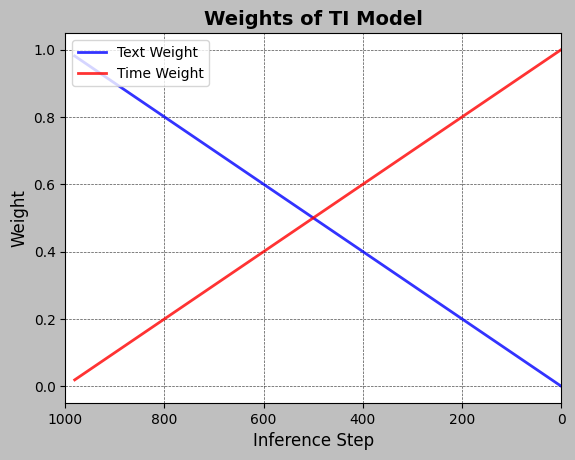

In [25]:
# TI weights
title = "Weights of TI Model"
inference_steps, text_weights, ip_weights = ip_model_time.get_weights()
plot_weights(title, inference_steps, text_weights, ip_weights, "./result/TI-IT-baseline/weights/ti_weights.png")

  0%|          | 0/50 [00:00<?, ?it/s]

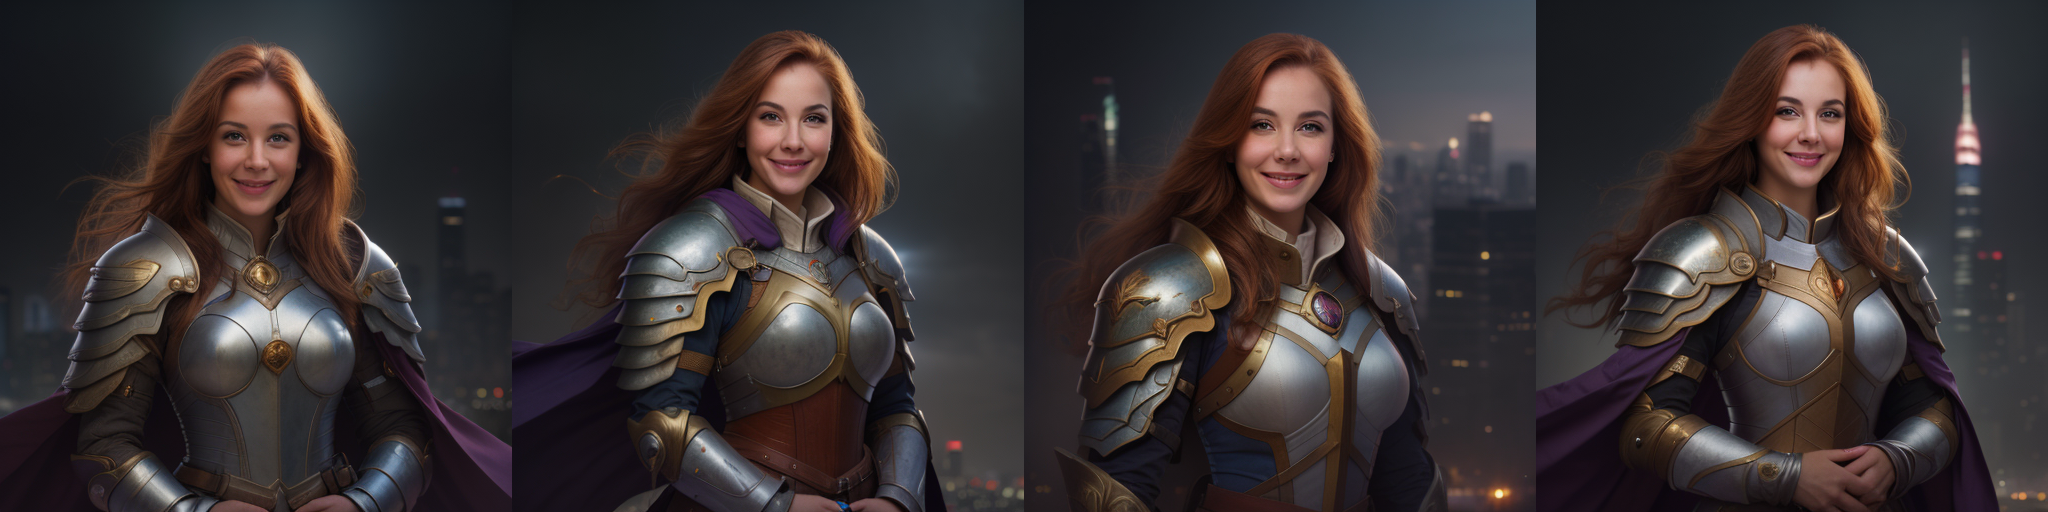

In [46]:
# IT with multi prompt
type = "it"
timestamp = time.strftime("%m%d%H%M%S")
output_image_path = os.getcwd() + f"/result/TI-IT-baseline/{type}_{timestamp}.png"
config_path = os.getcwd() + "/result/TI-IT-baseline/config.yaml"

images = ip_model_time.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42,
        prompt=text_prompt, scale=scale, TI=False)
grid = image_grid(images, 1, 4)
grid.show()
grid.save(output_image_path)
save_config(input_image_path, output_image_path, text_prompt, type, scale, config_path)

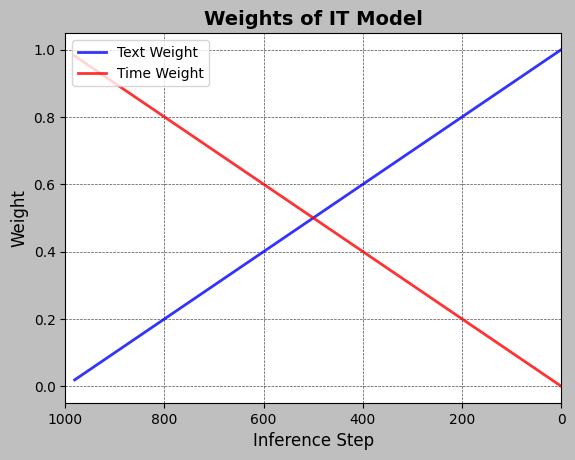

In [15]:
# IT weights
title = "Weights of IT Model"
inference_steps, text_weights, ip_weights = ip_model_time.get_weights()
plot_weights(title, inference_steps, text_weights, ip_weights, "./result/TI-IT-baseline/weights/it_weights.png")

In [30]:
for time in pipe_time.scheduler.timesteps:
    print((1/1000*time)**2+(-1/1000*time+1)**2)

tensor(0.9627, device='cuda:0')
tensor(0.9250, device='cuda:0')
tensor(0.8890, device='cuda:0')
tensor(0.8545, device='cuda:0')
tensor(0.8216, device='cuda:0')
tensor(0.7903, device='cuda:0')
tensor(0.7606, device='cuda:0')
tensor(0.7326, device='cuda:0')
tensor(0.7061, device='cuda:0')
tensor(0.6812, device='cuda:0')
tensor(0.6579, device='cuda:0')
tensor(0.6362, device='cuda:0')
tensor(0.6162, device='cuda:0')
tensor(0.5977, device='cuda:0')
tensor(0.5808, device='cuda:0')
tensor(0.5655, device='cuda:0')
tensor(0.5518, device='cuda:0')
tensor(0.5398, device='cuda:0')
tensor(0.5293, device='cuda:0')
tensor(0.5204, device='cuda:0')
tensor(0.5131, device='cuda:0')
tensor(0.5074, device='cuda:0')
tensor(0.5034, device='cuda:0')
tensor(0.5009, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5007, device='cuda:0')
tensor(0.5030, device='cuda:0')
tensor(0.5070, device='cuda:0')
tensor(0.5125, device='cuda:0')
tensor(0.5196, device='cuda:0')
tensor(0.5283, device='cuda:0')
tensor(0

In [28]:
5**2

25